# Capstone Project - Finding the Best Place to Open a New Juku Campus
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Juku is a kind of private fee-paying school in Japan for children to learn subjects such as maths or English after their regular school hours. Entrance exams are tough, especially for higher rank universities in Japan. So, students study hard to pass these exams in jukus offering supplementary lessons to students.<br><br>
I work for a juku where instructors teach maths and English to students from 5th grade to 12th grade. We search for the best place to open a new campus in Tokyo by leveraging location data obtained on the web in this project.

## Data <a name="data"></a>

We use two data set<br>
- tokyo_zip_latlong.csv
- tokyo_venues_zip500.csv

tokyo_zip_latlong has the geographical coordinates for all the zip_code of Tokyo.<br>
tokyo_venues_zip500 is venues information collected by Foursquare.<br>
We merge the two data for experiments. 

In [1]:
#conda install -c conda-forge geopy
# Importing required module 

import pandas as pd
import numpy as np

In [2]:
# imports all zip codes of Tokyo
tokyo_zip = pd.read_csv("./data/tokyo_zip_latlong.csv", index_col = 0)
tokyo_zip.head()

,zip_code,都,区,町,Prefecture,District,Area,lat,long
0,1000000,東京都,千代田区,以下に掲載がない場合,TOKYO TO,CHIYODA KU,IKANIKEISAIGANAIBAAI,NaN,NaN
1,1020072,東京都,千代田区,飯田橋,TOKYO TO,CHIYODA KU,IIDABASHI,NaN,NaN
2,1020082,東京都,千代田区,一番町,TOKYO TO,CHIYODA KU,ICHIBANCHO,35.729056,139.378416
3,1010032,東京都,千代田区,岩本町,TOKYO TO,CHIYODA KU,IWAMOTOCHO,35.695600,139.775379
4,1010047,東京都,千代田区,内神田,TOKYO TO,CHIYODA KU,UCHIKANDA,35.691038,139.767290


In [3]:
# import venues information
tokyo_venues = pd.read_csv("./data/tokyo_venues_zip500.csv")

# convert the venue data into one hot encoding
Tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add area column back to dataframe
Tokyo_onehot["zip_code"] = tokyo_venues["zip_code"]
Tokyo_onehot.set_index("zip_code", inplace = True)
Tokyo_onehot.reset_index(inplace = True)

#grouping rows by area and by taking the mean of the frequency of occurrence of each category
Tokyo_grouped = Tokyo_onehot.groupby('zip_code').mean().reset_index()
Tokyo_grouped.head()

,zip_code,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airfield,American Restaurant,Animal Shelter,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo,Zoo Exhibit
0,1000001,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.01,0.0,...,0.00,0.00,0.0,0.0,0.010000,0.00,0.000000,0.0,0.0,0.0
1,1000003,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.0,0.0,0.017544,0.00,0.017544,0.0,0.0,0.0
2,1000006,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.0,0.0,0.010000,0.01,0.020000,0.0,0.0,0.0
3,1000011,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.01,0.01,0.0,0.0,0.030000,0.00,0.030000,0.0,0.0,0.0
4,1000101,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0


In [4]:
# merge the data
zip_neighbor = tokyo_zip.merge(Tokyo_grouped, on = "zip_code")
zip_neighbor.dropna(inplace = True)
zip_neighbor.head()

,zip_code,都,区,町,Prefecture,District,Area,lat,long,ATM,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo,Zoo Exhibit
0,1020082,東京都,千代田区,一番町,TOKYO TO,CHIYODA KU,ICHIBANCHO,35.729056,139.378416,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
1,1010032,東京都,千代田区,岩本町,TOKYO TO,CHIYODA KU,IWAMOTOCHO,35.695600,139.775379,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0
2,1010047,東京都,千代田区,内神田,TOKYO TO,CHIYODA KU,UCHIKANDA,35.691038,139.767290,0.0,...,0.00,0.00,0.0,0.0,0.01,0.0,0.03,0.0,0.0,0.0
3,1000011,東京都,千代田区,内幸町,TOKYO TO,CHIYODA KU,UCHISAIWAICHO,35.669426,139.755460,0.0,...,0.01,0.01,0.0,0.0,0.03,0.0,0.03,0.0,0.0,0.0
4,1010044,東京都,千代田区,鍛冶町,TOKYO TO,CHIYODA KU,KAJICHO,35.691689,139.771942,0.0,...,0.00,0.00,0.0,0.0,0.01,0.0,0.02,0.0,0.0,0.0


## Methodology <a name="methodology"></a>

The first step is to reduce the data. We use the cosine similarity and pick data with top 40 cosine scores.<br>
The second step is to make clusters based on the 40 areas we choose in the previous step. The cluster including Shibuya is the target cluster.<br>

<b>1-1. Computing the cosine similarity.</b>

In [5]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# Shibuya campus info
shibuya_campus_zip = "1500002"
campus_zip_shibuya = zip_neighbor.query('zip_code == {}'.format(shibuya_campus_zip))
campus_zip_shibuya

,zip_code,都,区,町,Prefecture,District,Area,lat,long,ATM,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo,Zoo Exhibit
307,1500002,東京都,渋谷区,渋谷,TOKYO TO,SHIBUYA KU,SHIBUYA,35.66013,139.707191,0.0,...,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0


In [7]:
# make new vectors comprised of quantitative features for later use
campus_comp_vec = campus_zip_shibuya.drop(["zip_code", "都", "区", "町","Prefecture","District","Area", "lat", "long"], axis = 1)
all_comp_vec = zip_neighbor.drop(["zip_code", "都", "区", "町","Prefecture","District","Area", "lat", "long"], axis = 1)

#compute the cosine similarity and store the score in the DF
cos_score = cosine_similarity(campus_comp_vec, all_comp_vec)
zip_neighbor["cos_score"] = cos_score[0]

<b>1-2. Reducing the size of the data into top 40 highest cosine similarity score</b>

In [8]:
## obtain data of all of our campus for later use
campus_zip = ["1520035", "1800004", "1800005", "1600004"]
full_campus_sites = zip_neighbor.query('zip_code == {}'.format(campus_zip))
full_campus_sites = pd.concat([full_campus_sites, campus_zip_shibuya])


## obtain top 40 similar areas to the Shibuya campus

# remove our campuses data from data
zip_neighbor = zip_neighbor.query('zip_code != {}'.format(campus_zip))

## index 526 is ignored because it is a dupulicate of Yanaka (zip 1100001) in the data
similar_area = zip_neighbor.drop(526).sort_values("cos_score", ascending = False).head(41)
similar_area[["zip_code", "Area","cos_score"]] # 40 similar areas and Shibuya campus, in total 41 rows

,zip_code,Area,cos_score
307,1500002,SHIBUYA,1.000000
278,1540024,SANGENJAYA,0.801115
319,1500011,HIGASHI,0.773443
310,1500045,SHINSENCHO,0.759005
356,1670054,SHOAN,0.746051
9,1000001,CHIYODA,0.743232
72,1620043,WASEDA MINAMICHO,0.738410
627,1800003,KICHIJOJI MINAMICHO,0.736792
313,1500034,DAIKANYAMACHO,0.736470
311,1500041,JINNAN,0.731281


<b>2. Make clusters based on the 40 + shibuya campus data</b>

We use the elbow method to choose a good k parameter.<br>
In the elbow method, we plot the within-cluster sum-of-squares as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

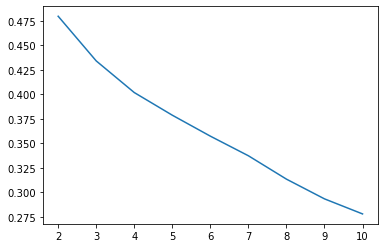

In [10]:
#find the best number of K trying from 2 to 10 by the elbow method

zip_neighbor_clustering = similar_area.drop(["zip_code", "都", "区", "町","Prefecture","District","Area", "lat", "long", "cos_score", ], axis = 1)

sum_of_squared = []
ks = [i + 2 for i in range(9)]
for k in ks:
    kclusters = k
    kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(zip_neighbor_clustering)
    sum_of_squared.append(kmeans.inertia_)

plt.plot(ks, sum_of_squared)
plt.show()


The sum of squared reduces mostly monotonically, and we cannot find an elbow point. So, we choose k = 10.

In [11]:
#build a model with k = 10
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(zip_neighbor_clustering)
similar_area["c_label"] = kmeans.labels_ #add the labels to the df

## Results and Discussion <a name="results"></a>

<b>Results</b>

Three areas fall in the same cluster as Shibuya campus; Sangenjaya, Higashi and Chiyoda.

In [12]:
#take Shibuya campus label
shibuya_label = similar_area.loc[307, "c_label"]

#print the similar area to shibuya, namely c_label = shibuya_label
c_shibuya = similar_area[similar_area["c_label"] == shibuya_label]
c_shibuya[["zip_code", "Area", "cos_score"]]

,zip_code,Area,cos_score
307,1500002,SHIBUYA,1.000000
278,1540024,SANGENJAYA,0.801115
319,1500011,HIGASHI,0.773443
9,1000001,CHIYODA,0.743232


Now, let's plot the candidate areas and all of our campuses data in a map.<br>
Our campuses are marked in red, the candidates are marked in blue.

In [13]:
import folium # map rendering library
from geopy.geocoders import Nominatim 

In [14]:
address = 'Tokyo'

geolocator = Nominatim(user_agent="tk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# plot all the candidates
campus_candidate_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add blue markers to map to visualize the cluster 0
for lat, lng, label in zip(c_shibuya['lat'], c_shibuya['long'], c_shibuya['Area']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(campus_candidate_map)  
    

#add red markers to map to visualize our campuses
for lat, lng, label in zip(full_campus_sites['lat'], full_campus_sites['long'], full_campus_sites['Area']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc4b31',
        fill_opacity=0.7,
        parse_html=False).add_to(campus_candidate_map)  
    

campus_candidate_map

<b>Discussion</b>

We observed three candidate areas for building a new campus; Sangenjaya, Higashi and Chiyoda. In my opinion, Chiyoda is the best location of all because the other areas are covered by three of our campuses already.

## Conclusion <a name="conclusion"></a>

In this project, we use location data to find candidte areas for our new campus. We use the Geopy for geocoding, the cosine similarity for reducing the number of candidates and k-means algorithm to find the best area.We observed that Chiyoda is the best area in respect of the location data we have obtained.<br><br>
Thank you for reading!